# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

(<Axes: >, <matplotlib.image.AxesImage at 0x107a27c50>)

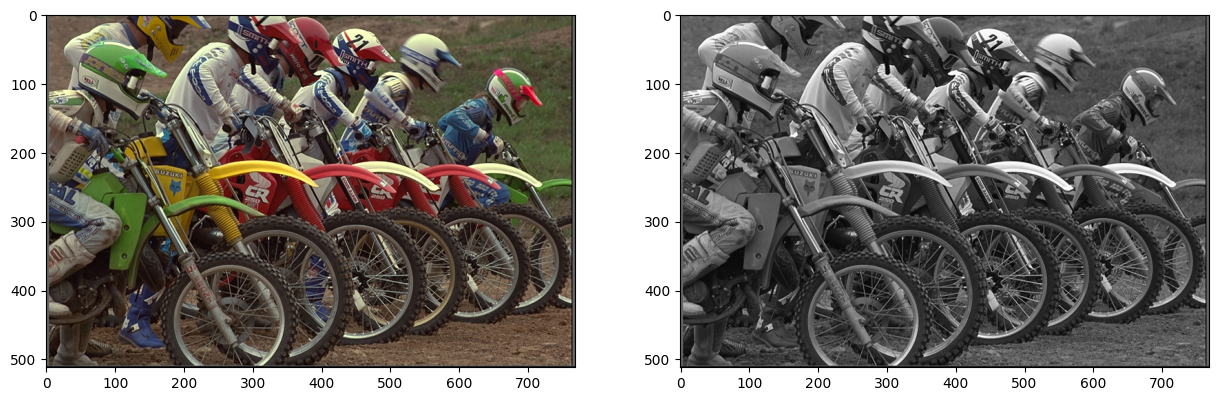

In [2]:
# Load image
img = cv2.imread('../data/kodim05.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Convert it to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# Plot it
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

Let's start with gray tones first.

In [3]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [4]:
# Cast the image to float
img = img.astype(np.float32)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c, :]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        dist = np.linalg.norm(colors - pixel, axis=1)
        new_pixel = colors[np.argmin(dist)]
        
        # Apply quantization
        quantized[r, c, :] = new_pixel

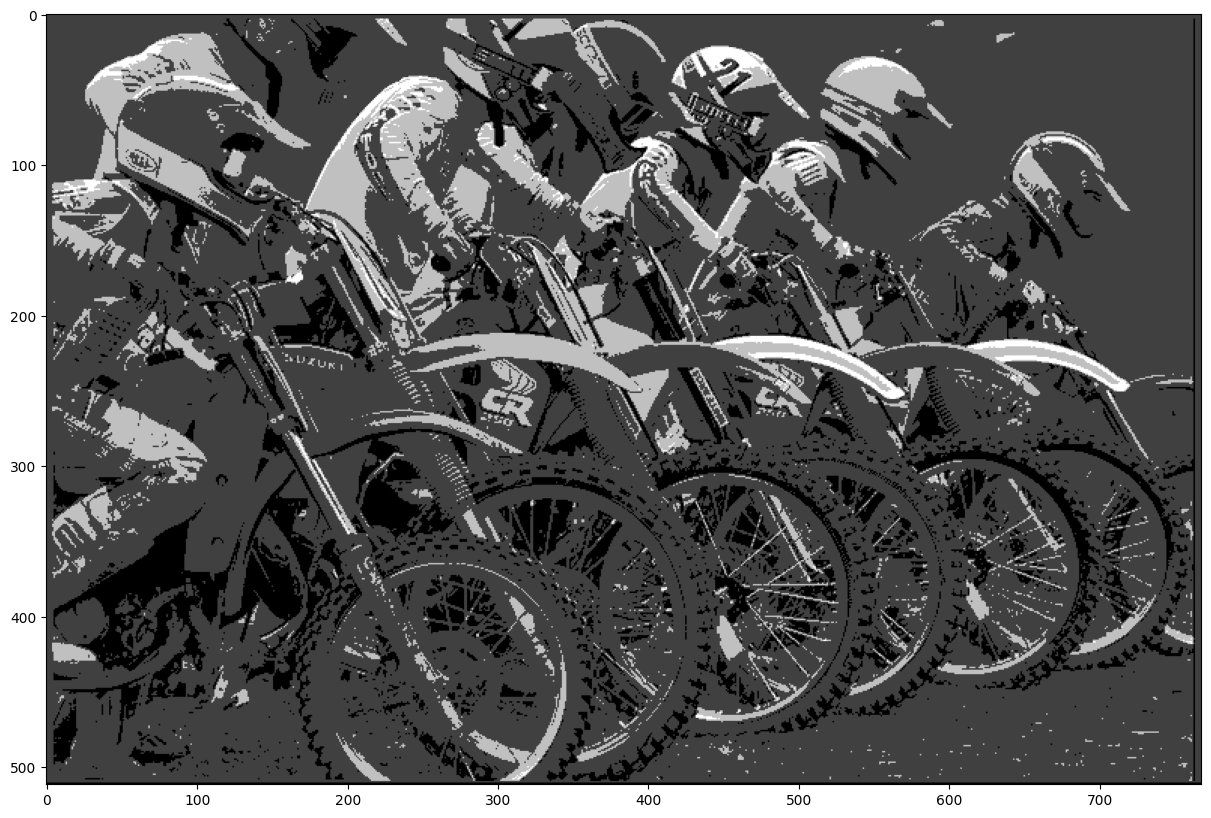

In [5]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(quantized.astype(np.uint8))

In [6]:
# Compute average quantization error (psnr)
def psnr(ref, target):
    error = ref.astype(np.float32) - target.astype(np.float32)
    mse = np.mean(error**2)
    return 10 * np.log10((255**2)/mse)
avg_quant_error = psnr(img, quantized)
avg_quant_error

17.821143858709707

#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [7]:
from tqdm import tqdm

# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
img_tmp = img_tmp.astype(np.float32)
dithering = np.zeros_like(img)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r, c, :]
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here

        dist = np.linalg.norm(colors - pixel, axis=1)
        new_pixel = colors[np.argmin(dist)]
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        img_tmp[r, c+1, :] += quant_error * 7/16
        img_tmp[r+1, c-1, :] += quant_error * 3/16
        img_tmp[r+1, c, :] += quant_error * 5/16
        img_tmp[r+1, c+1, :] += quant_error * 1/16
        
        # Apply dithering
        dithering[r, c, :] = new_pixel

(<Axes: >, <matplotlib.image.AxesImage at 0x151c011d0>)

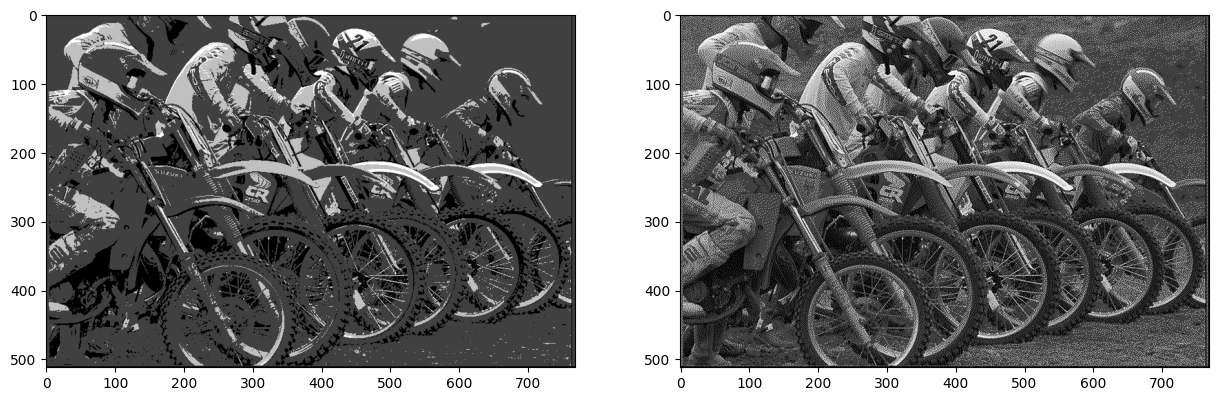

In [8]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized.astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow(dithering.astype(np.uint8))   # dithering

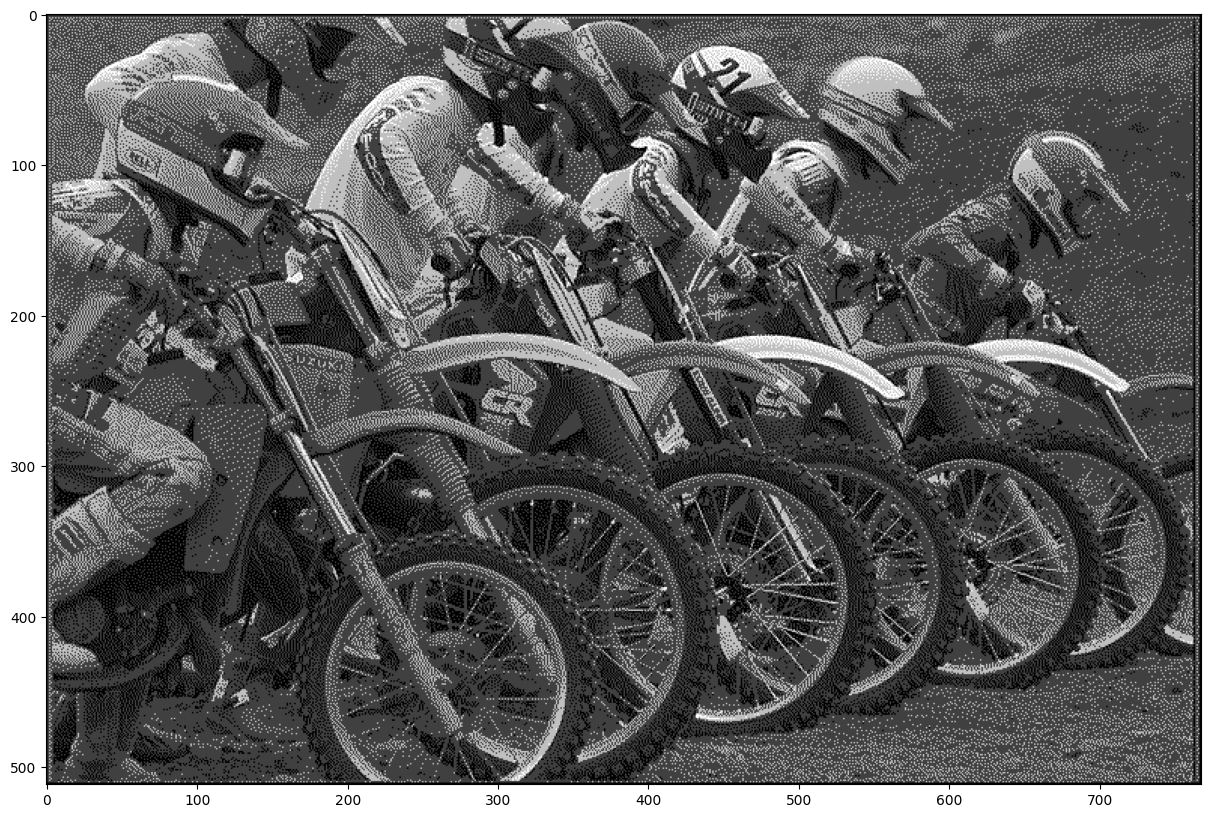

In [9]:
plt.imshow(dithering.astype(np.uint8))

In [10]:
# Compute average quantization error for dithered image
avg_dith_error = psnr(img, dithering)
avg_dith_error

15.589373532356577

### Questions
* Which image has higher quantization error? Optimally quantized or dithered?

выше ошибку имеет dithering, так как чем ниже значение тем хуже. но визульно dithering лучше. Floyd-Steinberg dithering добовляет "шум" на картинку. Алгоритм сглаживание распространяет "ошибку" на соседние пиксели, что делает визуально картинку более плавной. НО для psnr он будет хуже, так как примененное сжатие может достаточно сильно расходится с оригиналом, поэтому для оптимального квантования psnr выше, так как с точки зрения алгоритма там максимально похожие пиксели выбраны.

* Which image looks better to you?

кажись я ответил выше на это :)
* Can you repeat the same process using only two colours: black and white? Show me :-)

### Can you repeat the same process using only two colours: black and white? Show me :-)

In [11]:

colors_for_gray = np.array([0, 255])
img_tmp_g = np.copy(gray)
img_tmp_g = img_tmp_g.astype(np.float32)

rows, cols = gray.shape
dithering_gray = np.zeros_like(img)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        pixel = img_tmp_g[r, c]

        # dist = np.linalg.norm(colors_for_gray - pixel, axis=0)
        
        # для оттенка серого используем абсолютное значение разницы между пикселем и цветом (черный и белый)
        dist = np.abs(colors_for_gray - pixel)
        new_pixel = colors_for_gray[np.argmin(dist)]
        
        quant_error = pixel - new_pixel

        img_tmp_g[r, c+1] += quant_error * 7/16
        img_tmp_g[r+1, c-1] += quant_error * 3/16
        img_tmp_g[r+1, c] += quant_error * 5/16
        img_tmp_g[r+1, c+1] += quant_error * 1/16
        
        # Apply dithering
        dithering_gray[r, c] = new_pixel

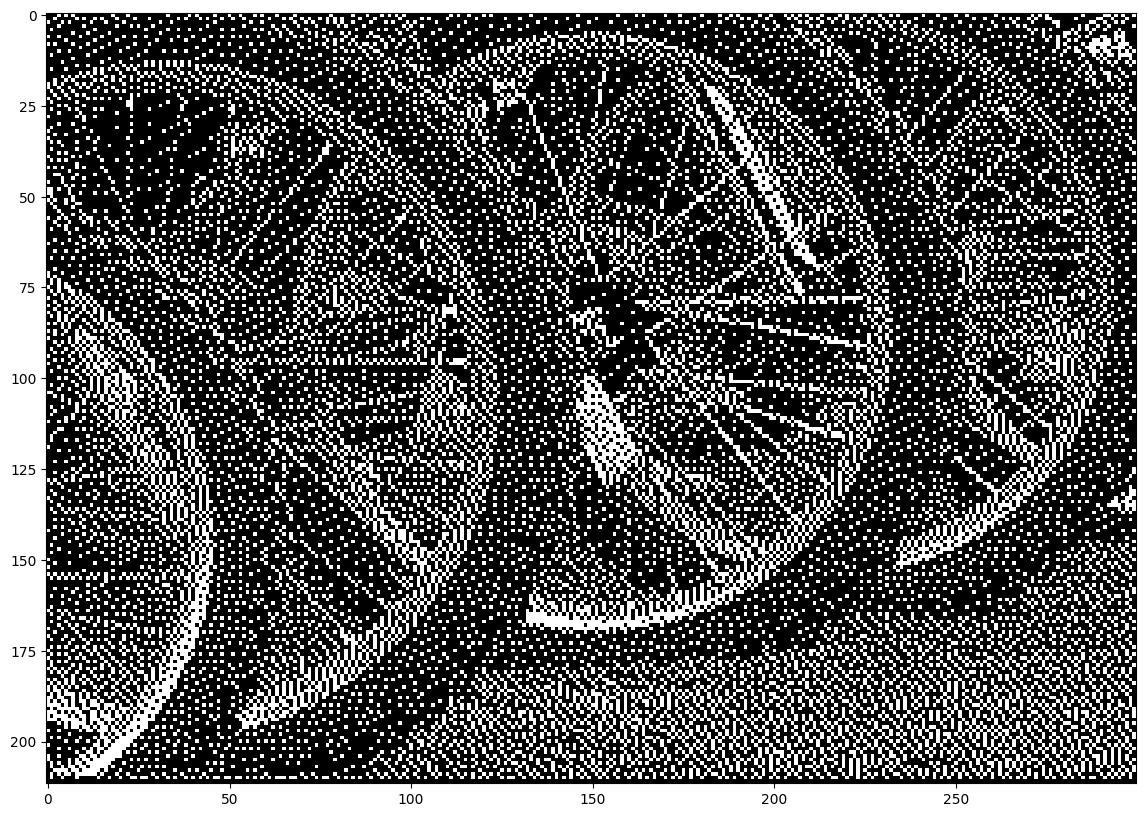

In [12]:
plt.imshow(dithering_gray.astype(np.uint8)[300:, 300:600], cmap='gray')

(<Axes: >, <matplotlib.image.AxesImage at 0x29cee89d0>)

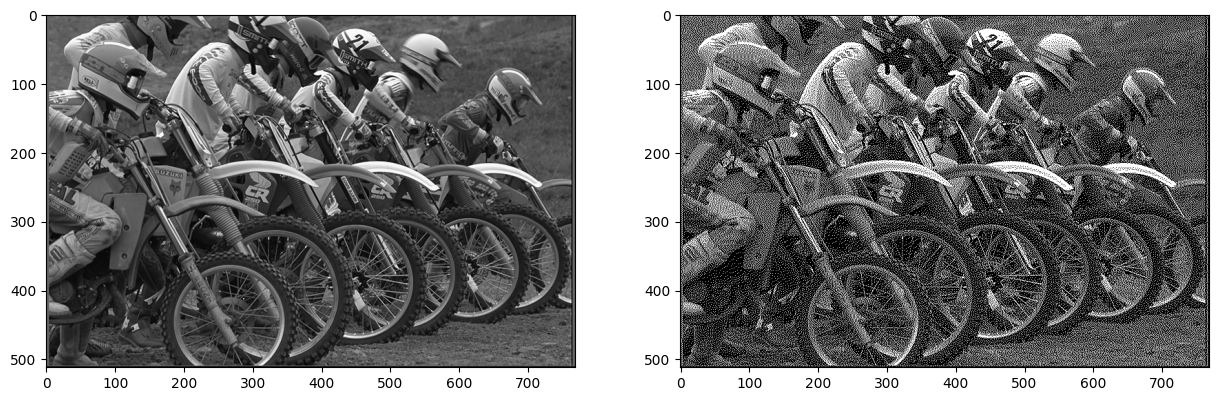

In [44]:
plt.subplot(121), plt.imshow(gray.astype(np.uint8), cmap='gray')
plt.subplot(122), plt.imshow(dithering_gray.astype(np.uint8))

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [37]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=32).fit(np.reshape(img, (-1, 3)))
colors = kmeans.cluster_centers_

In [38]:
img_tmp = np.copy(img)
img_tmp = img_tmp.astype(np.float32)
dithering = np.zeros_like(img)
quantized = np.zeros_like(img)

for r in range(rows):
    for c in range(cols):
        pixel = img[r, c, :]
        dist = np.linalg.norm(colors - pixel, axis=1)
        new_pixel = colors[np.argmin(dist)]
        quantized[r, c, :] = new_pixel
        
for r in range(1, rows-1):
    for c in range(1, cols-1):
        pixel = img_tmp[r, c, :]

        dist = np.linalg.norm(colors - pixel, axis=1)
        new_pixel = colors[np.argmin(dist)]
        
        quant_error = pixel - new_pixel
        
        img_tmp[r, c+1, :] += quant_error * 7/16
        img_tmp[r+1, c-1, :] += quant_error * 3/16
        img_tmp[r+1, c, :] += quant_error * 5/16
        img_tmp[r+1, c+1, :] += quant_error * 1/16
        
        dithering[r, c, :] = new_pixel

(<Axes: >, <matplotlib.image.AxesImage at 0x29cb3dd50>)

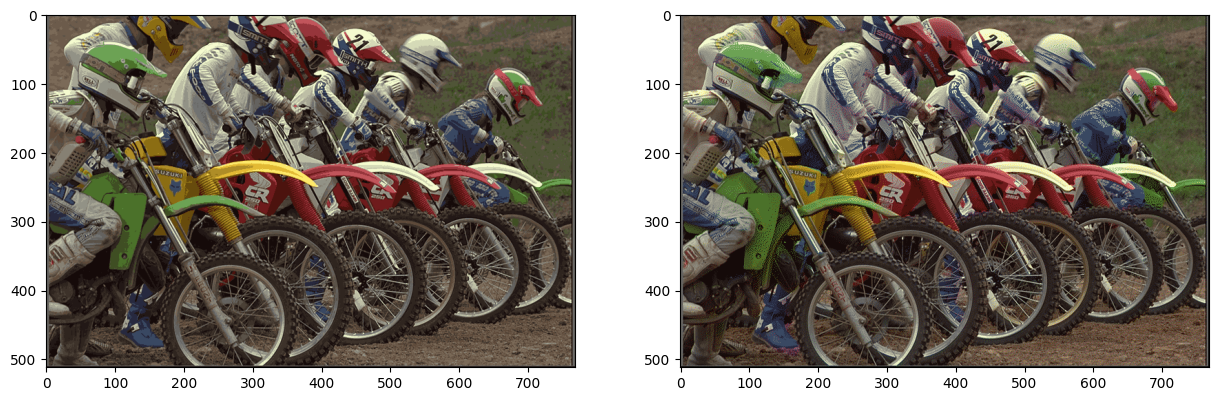

In [39]:
plt.subplot(121), plt.imshow(quantized.astype(np.uint8))
plt.subplot(122), plt.imshow(dithering.astype(np.uint8))

Apply FS dithering the same way you did before.
* How does the result look like to you?
* What happens if we use 32 colours?
* And what happens if we use 256 colours?

Конечно самый лучший "визуальный" результат достигается при испольщовании 256, но он и самй затратный. При использовании 16 видем много артефактов и возможной потери целого спектра цвета, еще и "залезание" одного цвета туда где его небыло. При 32 уже цвет больше сохраняется, но артефакты все еще присутствуют (например у первого гонщика цвет шлема вышел за границы). Если мы используе FS dithering, то он на только добовляет артефактов, особенно в облостях где небольшое количество вариантов цветов (из-за ошибки квантования). При 256 уже достаточно вариаций цветов и артефактов нет (возможно где-то минимальные) и уже квантование не может как-то существенно повлиять на результат.
